# Extracción de datos de Demanda Eléctrica

## Abstract

En el presente notebook se resume el proceso de extracción de los datos de **demanda eléctrica** para el período 2014-2021 mediante la consulta a la API de E.SIOS de Red Eléctrica.

Se extraen los datos de demanda a nivel mensual y horario para el período indicado anteriormente.

## 0. Importación de librerías

In [98]:
token = 'cb25867a53d723d058c6d15d29d416fc981bfe92d68e1709ae61ae0157806312'
token

'cb25867a53d723d058c6d15d29d416fc981bfe92d68e1709ae61ae0157806312'

In [99]:
url = 'https://api.esios.ree.es/indicators'

In [100]:
import requests
import numpy as np
import pandas as pd
import json

Cargamos también las rutas globales de los ficheros donde alojaremos los diferentes datasets.

In [101]:
global_path = '/home/berni/Documentos/tfm_data_science/version_0/Electric_Demand_Refactor/'
energy_datasets = global_path + 'data/energy_demand_data/energy_demand_datasets/'
temperature_datasets = global_path + 'data/temperature_data/temperature_datasets/'

## 1. Datos Mensuales

### Antigua forma de realizar la consulta a la API de E.SIOS

In [102]:
# mensual llamando a la api
start_date='01-01-2014T00:00:00 00:00'
end_date='31-12-2021T23:00:00 00:00'
date_type='datos'

url_resumen = 'https://api.esios.ree.es/indicators/1293/?start_date='+start_date+'&end_date='+end_date+'&time_trunc=month'
demanda_historico_mensual = requests.get(
    url_resumen, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Host' : 'api.esios.ree.es',
        'Content-Type':'application/json',
        'Authorization':'Token token="%s"' % (token),
        'Cookie': ''
    }
)

demanda_historico_mensual.json()

{'Status': 403, 'message': 'Forbidden'}

### Actualización de la consulta a la API de E.SIOS

Hacemos una consulta a la API de E.SIOS para saber los indicadores existentes. 

Nuestro objetivo es encontrar el indicador asociado a la Demanda Eléctrica para la Península Ibérica.

In [103]:
# mensual llamando a la api
start_date='01-01-2014T00:00:00 00:00'
end_date='31-12-2021T23:00:00 00:00'
date_type='datos'

url_indicators = 'https://api.esios.ree.es/indicators/?&start_date='+start_date+'&end_date='+end_date+'&date_type=datos'
indicators_esios = requests.get(
    url_indicators, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Content-Type': 'application/json',
        'x-api-key': token
    }
)

indicators_esios.json()

{'indicators': [{'name': 'Generación programada PBF Hidráulica UGH',
   'description': '<p>Es el programa de energía diario, con desglose horario, de las diferentes Unidades de Programación correspondientes a ventas y adquisiciones de energía en el sistema eléctrico peninsular español. En concreto este indicador se refiere a las unidades de programación con tipo de producción hidráulica UGH.</p><p>Este programa es establecido por el OS a partir de la casación del OM y de las nominaciones de programas de todas y cada una de las Unidades de Programación que le han sido comunicadas por los sujetos titulares de dichas Unidades de Programación, incluyendo las correspondientes a la ejecución de contratos bilaterales con entrega física de los cuales se ha confirmado la ejecución.</p><p><b>Publicación:</b> diariamente a partir de las 13:45 horas con la información del día D+1.</p>',
   'short_name': 'Hidráulica UGH',
   'id': 1},
  {'name': 'Generación programada PBF Hidráulica no UGH',
   'de

In [104]:
type(indicators_esios)

requests.models.Response

Guardamos el resultado en un archivo `.txt` para encontrar más cómodamente el ID asociado a la Demanda Real para la Península.

In [105]:
# Check if the request was successful:
if indicators_esios.status_code == 200:
    # Save response as .txt file:
    with open('indicators_esios.txt', 'w') as txt_file:
        txt_file.write(json.dumps(indicators_esios.json(), indent=4))
else:
    print(f'The API request was not successful. Status code: {indicators_esios.status_code}')

El indicador asociado a la Demanda real tiene el ID 1293. Las unidades de medida son MWh.

In [106]:
{
    "name": "Demanda real",
    "description": "<p>Es el valor real de la demanda de energ\u00eda el\u00e9ctrica medida en tiempo real.</p>\r\n<p>Los datos representados en este indicador se refieren a datos Peninsulares.</p>\r\n<p><b>Publicaci\u00f3n:</b> cada 5 minutos con la informaci\u00f3n de los 5 minutos anteriores.</p>",
    "short_name": "Demanda real",
    "id": 1293
 }

{'name': 'Demanda real',
 'description': '<p>Es el valor real de la demanda de energía eléctrica medida en tiempo real.</p>\r\n<p>Los datos representados en este indicador se refieren a datos Peninsulares.</p>\r\n<p><b>Publicación:</b> cada 5 minutos con la información de los 5 minutos anteriores.</p>',
 'short_name': 'Demanda real',
 'id': 1293}

Extrañamente, para fechas anteriores a 2015 se pueden hacer consultas de varios años a la vez, pero para fechas posteriores hay que realizar dichas consultas a la API año a año.

In [107]:
start_date='01-01-2000T00:00:00 00:00'
end_date='31-12-2014T00:00:00 00:00'
date_type='datos'

url_month = 'https://api.esios.ree.es/indicators/1293?&start_date='+start_date+'&end_date='+end_date+'&time_trunc=month'
historical_monthly_demand = requests.get(
    url_month, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Content-Type': 'application/json',
        'x-api-key': token
    }
)

historical_monthly_demand.json()

{'indicator': {'name': 'Demanda real',
  'short_name': 'Demanda real',
  'id': 1293,
  'composited': False,
  'step_type': 'linear',
  'disaggregated': False,
  'magnitud': [{'name': 'Potencia', 'id': 20}],
  'tiempo': [{'name': 'Diez minutos', 'id': 225}],
  'geos': [{'geo_id': 8741, 'geo_name': 'Península'}],
  'values_updated_at': '2016-12-20T11:53:03.000+01:00',
  'values': [{'value': 485654.0,
    'datetime': '2013-12-01T00:00:00.000+01:00',
    'datetime_utc': '2013-11-30T23:00:00Z',
    'tz_time': '2013-11-30T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'Península'},
   {'value': 132056990.0,
    'datetime': '2014-01-01T00:00:00.000+01:00',
    'datetime_utc': '2013-12-31T23:00:00Z',
    'tz_time': '2013-12-31T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'Península'},
   {'value': 121688438.0,
    'datetime': '2014-02-01T00:00:00.000+01:00',
    'datetime_utc': '2014-01-31T23:00:00Z',
    'tz_time': '2014-01-31T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'P

Realicemos las consultas año a año para el período 2014-2021.

In [108]:
# Define common parameters for the queries
start_date = '01-01-{0}T00:00:00 00:00'
end_date = '31-12-{0}T00:00:00 00:00'
date_type = 'datos'

# Initialize an empty dictionary to accumulate the data
accumulated_data = {}

# List of years to query
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

for year in years:
    # Create the query URL for the current year
    url_month = f'https://api.esios.ree.es/indicators/1293?&start_date={start_date.format(year)}&end_date={end_date.format(year)}&time_trunc=month'
    
    # Make the API request
    historical_monthly_demand = requests.get(
        url_month, 
        headers={
            'Accept': 'application/json; application/vnd.esios-api-v1+json',
            'Content-Type': 'application/json',
            'x-api-key': token
        }
    )
    
    # Check if the request was successful (status code 200)
    if historical_monthly_demand.status_code == 200:
        # Add the data to the accumulated dictionary, using the year as the key
        accumulated_data[str(year)] = historical_monthly_demand.json()
    else:
        print(f'The API request for the year {year} was not successful. Status code: {historical_monthly_demand.status_code}')

# The result will be in the accumulated dictionary
# You can access the data for a specific year using the year as the key
print(accumulated_data)

{'2014': {'indicator': {'name': 'Demanda real', 'short_name': 'Demanda real', 'id': 1293, 'composited': False, 'step_type': 'linear', 'disaggregated': False, 'magnitud': [{'name': 'Potencia', 'id': 20}], 'tiempo': [{'name': 'Diez minutos', 'id': 225}], 'geos': [{'geo_id': 8741, 'geo_name': 'Península'}], 'values_updated_at': '2016-12-20T11:53:03.000+01:00', 'values': [{'value': 131911180.0, 'datetime': '2014-01-01T00:00:00.000+01:00', 'datetime_utc': '2013-12-31T23:00:00Z', 'tz_time': '2013-12-31T23:00:00.000Z', 'geo_id': 8741, 'geo_name': 'Península'}, {'value': 121688438.0, 'datetime': '2014-02-01T00:00:00.000+01:00', 'datetime_utc': '2014-01-31T23:00:00Z', 'tz_time': '2014-01-31T23:00:00.000Z', 'geo_id': 8741, 'geo_name': 'Península'}, {'value': 124724746.0, 'datetime': '2014-03-01T00:00:00.000+01:00', 'datetime_utc': '2014-02-28T23:00:00Z', 'tz_time': '2014-02-28T23:00:00.000Z', 'geo_id': 8741, 'geo_name': 'Península'}, {'value': 112057243.0, 'datetime': '2014-04-01T00:00:00.000+02

In [109]:
accumulated_data['2021']

{'indicator': {'name': 'Demanda real',
  'short_name': 'Demanda real',
  'id': 1293,
  'composited': False,
  'step_type': 'linear',
  'disaggregated': False,
  'magnitud': [{'name': 'Potencia', 'id': 20}],
  'tiempo': [{'name': 'Diez minutos', 'id': 225}],
  'geos': [{'geo_id': 8741, 'geo_name': 'Península'}],
  'values_updated_at': '2021-12-31T01:09:00.000+01:00',
  'values': [{'value': 137473686.0,
    'datetime': '2021-01-01T00:00:00.000+01:00',
    'datetime_utc': '2020-12-31T23:00:00Z',
    'tz_time': '2020-12-31T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'Península'},
   {'value': 115952775.0,
    'datetime': '2021-02-01T00:00:00.000+01:00',
    'datetime_utc': '2021-01-31T23:00:00Z',
    'tz_time': '2021-01-31T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name': 'Península'},
   {'value': 125109453.0,
    'datetime': '2021-03-01T00:00:00.000+01:00',
    'datetime_utc': '2021-02-28T23:00:00Z',
    'tz_time': '2021-02-28T23:00:00.000Z',
    'geo_id': 8741,
    'geo_name':

Con el diccionario **accumulated_data** creamos un dataframe único para los datos de demanda mensual de cada año.

In [110]:
value=[]
date_record=[]
years_to_process = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
for year in years_to_process:
    for demand_value in accumulated_data[year]['indicator']['values']:
        value.append(demand_value['value'])
        date_record.append(demand_value['datetime'][:10])

In [111]:
demand_dataframe_month = pd.DataFrame({
    'date':date_record, 
    'value':value   
})

Verificamos que nuestro dataframe comienza con los primeros meses de 2014 y termina con los últimos meses del año 2021.

In [112]:
demand_dataframe_month.head()

,date,value
0,2014-01-01,131911180.0
1,2014-02-01,121688438.0
2,2014-03-01,124724746.0
3,2014-04-01,112057243.0
4,2014-05-01,116035410.0


In [113]:
demand_dataframe_month.tail(5)

,date,value
91,2021-08-01,125111628.0
92,2021-09-01,118590191.0
93,2021-10-01,114687519.0
94,2021-11-01,122396779.0
95,2021-12-01,122016048.0


Convertimos el dataframe a un csv.

In [114]:
demand_dataframe_month.to_csv(energy_datasets + '/monthly/energy_demand_monthly.csv', index=False)

Podemos simplificar el proceso usando las siguientes funciones.

In [115]:
def api_request(year, frequency):
    # Define common parameters for the queries
    start_date = '01-01-{0}T00:00:00 00:00'
    end_date = '31-12-{0}T00:00:00 00:00'
    date_type = 'datos'
    
    # Create the query URL for the current year
    url_month = f'https://api.esios.ree.es/indicators/1293?&start_date={start_date.format(year)}&end_date={end_date.format(year)}&time_trunc={frequency}'

    # Make the API request
    historical_monthly_demand = requests.get(
        url_month, 
        headers={
            'Accept': 'application/json; application/vnd.esios-api-v1+json',
            'Content-Type': 'application/json',
            'x-api-key': token
        }
    )

    # Check if the request was successful (status code 200)
    if historical_monthly_demand.status_code == 200:
        return historical_monthly_demand.json()
    else:
        print(f'The API request for the year {year} was not successful. Status code: {historical_monthly_demand.status_code}')

In [116]:
def energy_demand_extraction(start_year: int, end_year: int, frequency: str):
    # Define common parameters for the queries
    start_date = '01-01-{0}T00:00:00 00:00'
    end_date = '31-12-{0}T00:00:00 00:00'
    date_type = 'datos'

    # Initialize an empty dictionary to accumulate the data
    accumulated_data = {}

    # List of years to query
    years = list(range(start_year, end_year + 1))

    # Prepare data to a dataframe:
    value=[]
    date_record=[]
    hour=[]
    demand_values = {}
    for year in years:
        accumulated_data[str(year)] = api_request(year, frequency)
        for demand_value in accumulated_data[str(year)]['indicator']['values']:
            value.append(demand_value['value'])
            date_record.append(demand_value['datetime'][:10])
            if frequency == 'hour':
                hour.append(demand_value['datetime'][11:13])
                
    demand_values = {'date': date_record, 'value': value}
                
    if frequency == 'hour':
        demand_values = {'date': date_record, 'hour': hour, 'value': value}
        
    return pd.DataFrame(demand_values)

In [117]:
demand_dataframe_month = energy_demand_extraction(2014, 2021, 'month')
demand_dataframe_month

,date,value
0,2014-01-01,131911180.0
1,2014-02-01,121688438.0
2,2014-03-01,124724746.0
3,2014-04-01,112057243.0
4,2014-05-01,116035410.0
...,...,...
91,2021-08-01,125111628.0
92,2021-09-01,118590191.0
93,2021-10-01,114687519.0
94,2021-11-01,122396779.0


In [118]:
demand_dataframe_month.to_csv(energy_datasets + '/monthly/energy_demand_monthly.csv', index=False)

## 2. Datos Horarios

### 2.1. Extracción de datos horarios

In [119]:
demand_dataframe_hour = energy_demand_extraction(2014, 2021, 'hour')
demand_dataframe_hour

,date,hour,value
0,2014-01-01,01,140192.0
1,2014-01-01,02,130035.0
2,2014-01-01,03,121152.0
3,2014-01-01,04,115324.0
4,2014-01-01,05,113727.0
...,...,...,...
69939,2021-12-30,21,177517.0
69940,2021-12-30,22,165247.0
69941,2021-12-30,23,149899.0
69942,2021-12-31,00,140629.0


In [120]:
demand_dataframe_hour.to_csv(energy_datasets +'/hourly/energy_demand_hourly.csv', index=False)

### 2.2. Con días de la semana y festivos

#### 2.2.1. Días de la semana:

Vamos a añadir una nueva columna `weekday` en el que va a haber un valor según el día de la semana (Lunes=0, ..., Domingo=6).

In [121]:
demand_dataframe_hour = pd.read_csv(energy_datasets + 'hourly/energy_demand_hourly.csv')

In [122]:
demand_dataframe_hour['weekday'] = pd.to_datetime(demand_dataframe_hour['date']).apply(lambda x: x.weekday())

Comprobamos que los días de la semana van del 0 al 6.

In [123]:
demand_dataframe_hour.weekday.unique()

array([2, 3, 4, 5, 6, 0, 1])

In [124]:
demand_dataframe_hour.head()

,date,hour,value,weekday
0,2014-01-01,1,140192.0,2
1,2014-01-01,2,130035.0,2
2,2014-01-01,3,121152.0,2
3,2014-01-01,4,115324.0,2
4,2014-01-01,5,113727.0,2


In [125]:
demand_dataframe_hour.tail()

,date,hour,value,weekday
69939,2021-12-30,21,177517.0,3
69940,2021-12-30,22,165247.0,3
69941,2021-12-30,23,149899.0,3
69942,2021-12-31,0,140629.0,4
69943,2021-12-31,1,22413.0,4


#### 2.2.2. Día laboral o festivo

Para asignar dias festivos, podemos empezar con asignar los sábados y domingos como festivos. Para ello empleamos la siguiente función.

In [126]:
# if weekday is 5 or 6 (Saturday or Sunday) is not working day, else working day:
def is_working_day(day):
    return 0 if day == 5 or day == 6 else 1

Creamos una columna `working_day` en la que se asignará `0` si es día laboral, `1` si es festivo.

In [127]:
demand_dataframe_hour['working_day'] = demand_dataframe_hour['weekday'].apply(is_working_day)

Comprobamos que los valores son `0` y `1`.

In [128]:
demand_dataframe_hour.working_day.unique()

array([1, 0])

Consultamos los valores para un día determinado.

In [129]:
demand_dataframe_hour.loc[demand_dataframe_hour['date'] == '2014-08-15']

,date,hour,value,weekday,working_day
5422,2014-08-15,0,151159.0,4,1
5423,2014-08-15,1,141692.0,4,1
5424,2014-08-15,2,133955.0,4,1
5425,2014-08-15,3,129741.0,4,1
5426,2014-08-15,4,127019.0,4,1
5427,2014-08-15,5,125050.0,4,1
5428,2014-08-15,6,125591.0,4,1
5429,2014-08-15,7,124808.0,4,1
5430,2014-08-15,8,126699.0,4,1
5431,2014-08-15,9,135823.0,4,1


Buscamos los festivos a nivel nacional entre 2014 y 2021 y los concatenamos después:

In [130]:
festives_spain_2014 = [
    '2014-01-01', '2014-01-06', '2014-04-17', '2014-04-18', '2014-05-01', 
    '2014-06-19', '2014-08-15', '2014-11-01', '2014-12-06', '2014-12-08', '2014-12-25'
]

In [131]:
festives_spain_2015 = [
    '2015-01-01', '2015-01-06', '2015-04-02', '2015-04-03',
    '2015-05-01', '2015-10-12', '2015-11-01', 
    '2015-12-06', '2015-12-08', '2015-12-25'
]

In [132]:
festives_spain_2016 = [
    '2016-01-01', '2016-01-06', '2016-03-24', '2016-03-25',
    '2016-05-01', '2016-08-15', '2016-10-12', 
    '2016-11-01', '2016-12-06', '2016-12-08',
    '2016-12-25'
]

In [133]:
festives_spain_2017 = [
    '2017-01-01', '2017-01-06', '2017-04-13', '2017-04-14', '2017-05-01',
    '2017-08-15', '2017-10-12', '2017-11-01', '2017-12-06',
    '2017-12-08', '2017-12-25'
]

In [134]:
festives_spain_2018 = [
    '2018-01-01', '2018-01-06', '2018-03-29', '2018-03-30', '2018-05-01',
    '2018-08-15', '2018-10-12', '2018-11-01', '2018-12-06',
    '2018-12-08', '2018-12-25'
]

In [135]:
festives_spain_2019 = [
    '2019-01-01', '2019-01-06', '2019-04-18', '2019-04-19',
    '2019-05-01', '2019-08-15', '2019-10-12', '2019-11-01',
    '2019-12-06', '2019-12-08', '2019-12-25'
]

In [136]:
festives_spain_2020 = [
    '2020-01-01', '2020-01-06', '2020-04-09', '2020-04-10',
    '2020-05-01', '2020-08-15', '2020-10-12', '2020-11-01',
    '2020-12-06', '2020-12-08', '2020-12-25'
]

In [137]:
festives_spain_2021 = [
    '2021-01-01', '2021-01-06', '2021-04-01', '2021-04-02',
    '2021-05-01', '2021-08-15', '2021-10-12', '2021-11-01',
    '2021-12-06', '2021-12-08', '2021-12-25'
]

In [138]:
festives_spain_2022 = [
    '2022-01-01', '2022-01-06', '2022-04-14', '2022-04-15',
    '2022-05-01', '2022-08-15', '2022-10-12', '2022-11-01',
    '2022-12-06', '2022-12-08', '2022-12-25'
]

In [139]:
festives_spain_2014_2021 = festives_spain_2014 + festives_spain_2015 + festives_spain_2016 + festives_spain_2017 + festives_spain_2018 + festives_spain_2019 + festives_spain_2020 + festives_spain_2021

In [140]:
festives_spain_2014_2022 = festives_spain_2014 + festives_spain_2015 + festives_spain_2016 + festives_spain_2017 + festives_spain_2018 + festives_spain_2019 + festives_spain_2020 + festives_spain_2021 + festives_spain_2022

Creamos una función para asignar como laboral o festivo a nivel nacional los días de nuestro dataset.

In [141]:
def is_national_festive(date):
    return 0 if date in festives_spain_2014_2021 else 1

In [142]:
demand_dataframe_hour['working_day'] = demand_dataframe_hour['date'].apply(is_national_festive)

demand_dataframe_hour['value'] = demand_dataframe_hour.pop('value')

Comprobamos que el día festivo que usamos como referencia, ahora figura como día festivo:

In [143]:
demand_dataframe_hour.loc[demand_dataframe_hour['date'] == '2014-08-15']

,date,hour,weekday,working_day,value
5422,2014-08-15,0,4,0,151159.0
5423,2014-08-15,1,4,0,141692.0
5424,2014-08-15,2,4,0,133955.0
5425,2014-08-15,3,4,0,129741.0
5426,2014-08-15,4,4,0,127019.0
5427,2014-08-15,5,4,0,125050.0
5428,2014-08-15,6,4,0,125591.0
5429,2014-08-15,7,4,0,124808.0
5430,2014-08-15,8,4,0,126699.0
5431,2014-08-15,9,4,0,135823.0


Vemos que ha cambiado la columna `working_day` una vez aplicada la función.

In [144]:
demand_dataframe_hour.to_csv(energy_datasets + 'hourly/energy_demand_hourly_weekday_festive.csv', index=False)

Extraemos una semana de prueba.

In [145]:
demand_hour_v2_test_week = demand_dataframe_hour.loc[
    demand_dataframe_hour['date'].isin([
        '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', 
        '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08'
    ])
]
demand_hour_v2_test_week

,date,hour,weekday,working_day,value
0,2014-01-01,1,2,0,140192.0
1,2014-01-01,2,2,0,130035.0
2,2014-01-01,3,2,0,121152.0
3,2014-01-01,4,2,0,115324.0
4,2014-01-01,5,2,0,113727.0
...,...,...,...,...,...
186,2014-01-08,19,2,1,214267.0
187,2014-01-08,20,2,1,214905.0
188,2014-01-08,21,2,1,210905.0
189,2014-01-08,22,2,1,195654.0


In [146]:
demand_hour_v2_test_week['date'] = pd.to_datetime(demand_hour_v2_test_week.date) + pd.to_timedelta(demand_hour_v2_test_week.hour, unit='h')
del demand_hour_v2_test_week['hour']
demand_hour_v2_test_week

/tmp/ipykernel_4394/3449523844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_hour_v2_test_week['date'] = pd.to_datetime(demand_hour_v2_test_week.date) + pd.to_timedelta(demand_hour_v2_test_week.hour, unit='h')


,date,weekday,working_day,value
0,2014-01-01 01:00:00,2,0,140192.0
1,2014-01-01 02:00:00,2,0,130035.0
2,2014-01-01 03:00:00,2,0,121152.0
3,2014-01-01 04:00:00,2,0,115324.0
4,2014-01-01 05:00:00,2,0,113727.0
...,...,...,...,...
186,2014-01-08 19:00:00,2,1,214267.0
187,2014-01-08 20:00:00,2,1,214905.0
188,2014-01-08 21:00:00,2,1,210905.0
189,2014-01-08 22:00:00,2,1,195654.0


In [147]:
demand_hour_v2_test_week.set_index("date", inplace=True)
demand_hour_v2_test_week.head(2)

,weekday,working_day,value
date,,,
2014-01-01 01:00:00,2,0,140192.0
2014-01-01 02:00:00,2,0,130035.0


In [148]:
demand_hour_v2_test_week = demand_hour_v2_test_week.resample('H').first()

In [149]:
demand_hour_v2_test_week.index.freq

<Hour>

In [150]:
demand_hour_v2_test_week.index

DatetimeIndex(['2014-01-01 01:00:00', '2014-01-01 02:00:00',
               '2014-01-01 03:00:00', '2014-01-01 04:00:00',
               '2014-01-01 05:00:00', '2014-01-01 06:00:00',
               '2014-01-01 07:00:00', '2014-01-01 08:00:00',
               '2014-01-01 09:00:00', '2014-01-01 10:00:00',
               ...
               '2014-01-08 14:00:00', '2014-01-08 15:00:00',
               '2014-01-08 16:00:00', '2014-01-08 17:00:00',
               '2014-01-08 18:00:00', '2014-01-08 19:00:00',
               '2014-01-08 20:00:00', '2014-01-08 21:00:00',
               '2014-01-08 22:00:00', '2014-01-08 23:00:00'],
              dtype='datetime64[ns]', name='date', length=191, freq='H')

<Axes: xlabel='date'>

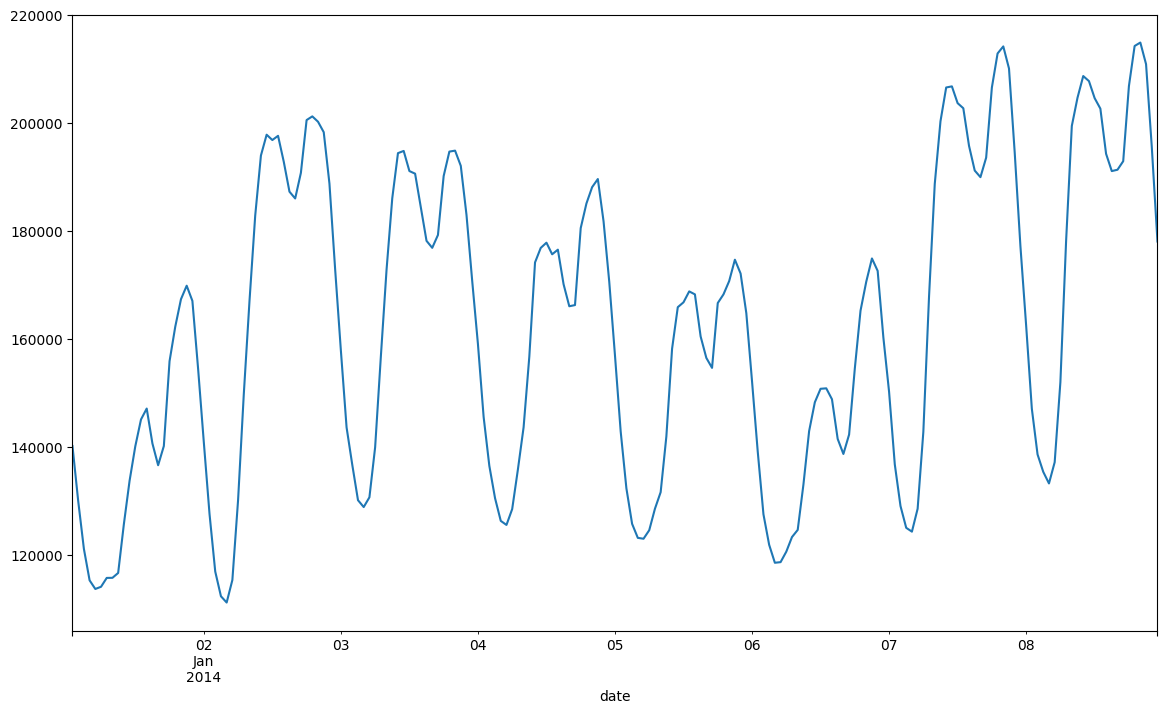

In [151]:
demand_hour_v2_test_week['value'].plot(figsize=(14,8))

### 2.3. Con días de la semana, festivos y temperatura

Leemos el fichero de temperaturas de 5 ciudades para el período 2014-2022.

In [152]:
data_temp = pd.read_csv(temperature_datasets + 'final/temp_data_2014_2022.csv')
del data_temp['Unnamed: 0']

In [153]:
data_temp

,date,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
0,2014-01-01,0,4.69985,4.82314,7.79263,9.41128,10.86538
1,2014-01-01,1,4.59854,4.57510,6.95278,9.13394,10.87760
2,2014-01-01,2,4.65054,4.45498,6.63174,9.30117,10.91030
3,2014-01-01,3,4.71353,4.49868,7.63442,9.53726,10.86562
4,2014-01-01,4,4.80654,4.52236,9.08853,9.85757,10.86440
...,...,...,...,...,...,...,...
71540,2022-02-28,20,10.96010,10.00160,10.66055,15.38467,11.31730
71541,2022-02-28,21,9.48380,9.52505,9.47500,13.25698,10.29922
71542,2022-02-28,22,8.09610,8.93716,9.06484,12.03090,9.78700
71543,2022-02-28,23,7.30972,8.22085,8.95205,12.30728,8.31997


Eliminamos los datos referentes a 2002.

In [154]:
data_temp = data_temp[~data_temp.date.str.contains("2022")]

Leemos el fichero con datos de demanda eléctrica por horas que incluyen además los días de la semana y festivos.

In [155]:
demand_dataframe_hour = pd.read_csv(energy_datasets + 'hourly/energy_demand_hourly_weekday_festive.csv')
demand_dataframe_hour

,date,hour,weekday,working_day,value
0,2014-01-01,1,2,0,140192.0
1,2014-01-01,2,2,0,130035.0
2,2014-01-01,3,2,0,121152.0
3,2014-01-01,4,2,0,115324.0
4,2014-01-01,5,2,0,113727.0
...,...,...,...,...,...
69939,2021-12-30,21,3,1,177517.0
69940,2021-12-30,22,3,1,165247.0
69941,2021-12-30,23,3,1,149899.0
69942,2021-12-31,0,4,1,140629.0


Mergeamos ambos dataframes usando `date` y `hour`.

In [156]:
demand_hour_temp_resume = pd.merge(data_temp, demand_dataframe_hour, how='inner', on=['date', 'hour'])
demand_hour_temp_resume.to_csv(energy_datasets + 'hourly/energy_demand_hour_temp_resume.csv', index=False)

demand_hour_temp_resume = pd.read_csv(energy_datasets + 'hourly/energy_demand_hour_temp_resume.csv')
demand_hour_temp_resume

,date,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,value
0,2014-01-01,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,140192.0
1,2014-01-01,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,130035.0
2,2014-01-01,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,121152.0
3,2014-01-01,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,115324.0
4,2014-01-01,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,113727.0
...,...,...,...,...,...,...,...,...,...,...
69939,2021-12-30,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,177517.0
69940,2021-12-30,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,165247.0
69941,2021-12-30,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,149899.0
69942,2021-12-31,0,5.55337,8.61147,10.57020,9.14126,8.70303,4,1,140629.0


### 2.4. Con días de la semana, festivos, temperatura y estacionalidad (verano/invierno)

En este apartado, añadimos una nueva columna que representará la estacionalidad (verano o invierno) de cada día del dataset, siguiendo el siguiente esquema:

* **invierno:** 21 de diciembre - 20 de marzo.
* **verano:** 21 de junio - 23 de septiembre.

In [157]:
demand_hour_temp_resume = pd.read_csv(energy_datasets + 'hourly/energy_demand_hour_temp_resume.csv')
demand_hour_temp_resume

,date,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,value
0,2014-01-01,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,140192.0
1,2014-01-01,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,130035.0
2,2014-01-01,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,121152.0
3,2014-01-01,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,115324.0
4,2014-01-01,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,113727.0
...,...,...,...,...,...,...,...,...,...,...
69939,2021-12-30,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,177517.0
69940,2021-12-30,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,165247.0
69941,2021-12-30,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,149899.0
69942,2021-12-31,0,5.55337,8.61147,10.57020,9.14126,8.70303,4,1,140629.0


In [158]:
years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

dataframe_resume = pd.DataFrame()
dataframe_resume_list = []

for year in years:
    demand_hour_temp_resume['year'] = pd.DatetimeIndex(demand_hour_temp_resume['date']).year

    demand_hour_temp_resume_year = demand_hour_temp_resume[demand_hour_temp_resume['year'] == int(year)]
    demand_hour_temp_resume_year['date'] = demand_hour_temp_resume_year['date'].apply(
        pd.to_datetime, format='%Y-%m-%d'
    )
        
    if year == '2021':
        winter_start = '2021'
        winter_end = '2022'
    else:
        winter_start = str(int(year)-1)
        winter_end = year
    
    in_between_winter = demand_hour_temp_resume_year.date.between(winter_start+'-12-21', winter_end+'-03-20')
    demand_hour_temp_resume_year['is_winter'] = np.where(in_between_winter, 1, 0)
    
    in_between_summer = demand_hour_temp_resume_year.date.between(year+'-06-21', year+'-09-23')
    demand_hour_temp_resume_year['is_summer'] = np.where(in_between_summer, 1, 0)

    dataframe_resume_list.append(demand_hour_temp_resume_year)
    
dataframe_resume = pd.concat(dataframe_resume_list, ignore_index=True)
    
del dataframe_resume['year']

dataframe_resume['value'] = dataframe_resume.pop('value')

/tmp/ipykernel_4394/336201253.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_hour_temp_resume_year['date'] = demand_hour_temp_resume_year['date'].apply(
/tmp/ipykernel_4394/336201253.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_hour_temp_resume_year['is_winter'] = np.where(in_between_winter, 1, 0)
/tmp/ipykernel_4394/336201253.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [159]:
dataframe_resume

,date,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
0,2014-01-01,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
1,2014-01-01,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2,2014-01-01,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
3,2014-01-01,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
4,2014-01-01,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69939,2021-12-30,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
69940,2021-12-30,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
69941,2021-12-30,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0
69942,2021-12-31,0,5.55337,8.61147,10.57020,9.14126,8.70303,4,1,1,0,140629.0


In [160]:
dataframe_resume.to_csv(energy_datasets + 'hourly/energy_demand_hour_temp_seasonal_resume.csv', index=False)

demand_hour_temp_seasonal_resume = pd.read_csv(energy_datasets + 'hourly/energy_demand_hour_temp_seasonal_resume.csv')
demand_hour_temp_seasonal_resume

,date,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
0,2014-01-01,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
1,2014-01-01,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2,2014-01-01,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
3,2014-01-01,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
4,2014-01-01,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69939,2021-12-30,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
69940,2021-12-30,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
69941,2021-12-30,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0
69942,2021-12-31,0,5.55337,8.61147,10.57020,9.14126,8.70303,4,1,1,0,140629.0


## 3. Datos Diarios

### 3.1. Extracción de datos diarios

In [161]:
demand_dataframe_day = energy_demand_extraction(2014, 2021, 'day')
demand_dataframe_day

,date,value
0,2014-01-01,3315035.0
1,2014-01-02,4059590.0
2,2014-01-03,4098986.0
3,2014-01-04,3867911.0
4,2014-01-05,3648038.0
...,...,...
2917,2021-12-27,3686647.0
2918,2021-12-28,3729169.0
2919,2021-12-29,3692921.0
2920,2021-12-30,3689439.0


In [162]:
demand_dataframe_day['weekday'] = pd.to_datetime(demand_dataframe_day['date']).apply(lambda x: x.weekday())

In [163]:
demand_dataframe_day['working_day'] = demand_dataframe_day['weekday'].apply(is_working_day)

In [164]:
demand_dataframe_day['working_day'] = demand_dataframe_day['date'].apply(is_national_festive)

In [165]:
demand_dataframe_day['value'] = demand_dataframe_day.pop('value')
demand_dataframe_day

,date,weekday,working_day,value
0,2014-01-01,2,0,3315035.0
1,2014-01-02,3,1,4059590.0
2,2014-01-03,4,1,4098986.0
3,2014-01-04,5,1,3867911.0
4,2014-01-05,6,1,3648038.0
...,...,...,...,...
2917,2021-12-27,0,1,3686647.0
2918,2021-12-28,1,1,3729169.0
2919,2021-12-29,2,1,3692921.0
2920,2021-12-30,3,1,3689439.0


In [166]:
demand_dataframe_day.to_csv(energy_datasets + 'daily/energy_demand_daily_weekday_festive.csv', index=False)

### 3.2. Con días de la semana, festivos y temperatura

Pasamos el fichero de temperaturas de valores horarios a diarios.

In [167]:
data_temp_daily = data_temp.groupby('date').mean().reset_index()
del data_temp_daily['hour']
data_temp_daily

,date,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
0,2014-01-01,6.785193,8.006851,11.418970,12.184413,13.189499
1,2014-01-02,9.109185,10.764683,12.935602,14.524325,15.136449
2,2014-01-03,9.776889,11.935958,13.029657,15.653018,16.565861
3,2014-01-04,6.703811,11.307489,9.814500,14.106683,14.699295
4,2014-01-05,5.285333,8.682916,9.971085,10.653680,10.970076
...,...,...,...,...,...,...
2917,2021-12-27,11.606002,13.531011,14.285517,17.009720,17.443636
2918,2021-12-28,9.792129,14.261092,14.133620,16.015375,16.007968
2919,2021-12-29,8.401157,13.250848,12.936356,13.320164,15.173263
2920,2021-12-30,7.203344,11.992122,12.347234,12.666560,12.678245


In [168]:
demand_dataframe_day_temp_fest = pd.merge(demand_dataframe_day, data_temp_daily, how='inner', on=['date'])
demand_dataframe_day_temp_fest['value'] = demand_dataframe_day_temp_fest.pop('value')
demand_dataframe_day_temp_fest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            2922 non-null   object 
 1   weekday         2922 non-null   int64  
 2   working_day     2922 non-null   int64  
 3   madrid_temp     2922 non-null   float64
 4   barcelona_temp  2922 non-null   float64
 5   bilbao_temp     2922 non-null   float64
 6   sevilla_temp    2922 non-null   float64
 7   valencia_temp   2922 non-null   float64
 8   value           2922 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 205.6+ KB


In [169]:
demand_dataframe_day_temp_fest

,date,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,value
0,2014-01-01,2,0,6.785193,8.006851,11.418970,12.184413,13.189499,3315035.0
1,2014-01-02,3,1,9.109185,10.764683,12.935602,14.524325,15.136449,4059590.0
2,2014-01-03,4,1,9.776889,11.935958,13.029657,15.653018,16.565861,4098986.0
3,2014-01-04,5,1,6.703811,11.307489,9.814500,14.106683,14.699295,3867911.0
4,2014-01-05,6,1,5.285333,8.682916,9.971085,10.653680,10.970076,3648038.0
...,...,...,...,...,...,...,...,...,...
2917,2021-12-27,0,1,11.606002,13.531011,14.285517,17.009720,17.443636,3686647.0
2918,2021-12-28,1,1,9.792129,14.261092,14.133620,16.015375,16.007968,3729169.0
2919,2021-12-29,2,1,8.401157,13.250848,12.936356,13.320164,15.173263,3692921.0
2920,2021-12-30,3,1,7.203344,11.992122,12.347234,12.666560,12.678245,3689439.0


In [170]:
demand_dataframe_day_temp_fest.to_csv(energy_datasets + 'daily/energy_demand_daily_weekday_temp_resume.csv', index=False)

### 3.3. Con días de la semana, festivos, temperatura y estacionalidad (verano/invierno)

In [171]:
demand_day_temp_resume = pd.read_csv(energy_datasets + 'daily/energy_demand_daily_weekday_temp_resume.csv')
demand_day_temp_resume

,date,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,value
0,2014-01-01,2,0,6.785193,8.006851,11.418970,12.184413,13.189499,3315035.0
1,2014-01-02,3,1,9.109185,10.764683,12.935602,14.524325,15.136449,4059590.0
2,2014-01-03,4,1,9.776889,11.935958,13.029657,15.653018,16.565861,4098986.0
3,2014-01-04,5,1,6.703811,11.307489,9.814500,14.106683,14.699295,3867911.0
4,2014-01-05,6,1,5.285333,8.682916,9.971085,10.653680,10.970076,3648038.0
...,...,...,...,...,...,...,...,...,...
2917,2021-12-27,0,1,11.606002,13.531011,14.285517,17.009720,17.443636,3686647.0
2918,2021-12-28,1,1,9.792129,14.261092,14.133620,16.015375,16.007968,3729169.0
2919,2021-12-29,2,1,8.401157,13.250848,12.936356,13.320164,15.173263,3692921.0
2920,2021-12-30,3,1,7.203344,11.992122,12.347234,12.666560,12.678245,3689439.0


In [179]:
demand_day_temp_resume = pd.read_csv(energy_datasets + 'daily/energy_demand_daily_weekday_temp_resume.csv')
demand_day_temp_resume

years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

dataframe_resume = pd.DataFrame()
dataframe_resume_list = []

for year in years:
    demand_day_temp_resume['year'] = pd.DatetimeIndex(demand_day_temp_resume['date']).year

    demand_day_temp_resume_year = demand_day_temp_resume[demand_day_temp_resume['year'] == int(year)]
    demand_day_temp_resume_year['date'] = demand_day_temp_resume_year['date'].apply(
        pd.to_datetime, format='%Y-%m-%d'
    )
        
    if year == '2021':
        winter_start = '2021'
        winter_end = '2022'
    else:
        winter_start = str(int(year)-1)
        winter_end = year
    
    in_between_winter = demand_day_temp_resume_year.date.between(winter_start+'-12-21', winter_end+'-03-20')
    demand_day_temp_resume_year['is_winter'] = np.where(in_between_winter, 1, 0)
    
    in_between_summer = demand_day_temp_resume_year.date.between(year+'-06-21', year+'-09-23')
    demand_day_temp_resume_year['is_summer'] = np.where(in_between_summer, 1, 0)

    dataframe_resume_list.append(demand_day_temp_resume_year)
    
dataframe_resume = pd.concat(dataframe_resume_list, ignore_index=True)
    
del dataframe_resume['year']

dataframe_resume['value'] = dataframe_resume.pop('value')

/tmp/ipykernel_4394/3281346120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_day_temp_resume_year['date'] = demand_day_temp_resume_year['date'].apply(
/tmp/ipykernel_4394/3281346120.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_day_temp_resume_year['is_winter'] = np.where(in_between_winter, 1, 0)
/tmp/ipykernel_4394/3281346120.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [180]:
dataframe_resume

,date,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer,value
0,2014-01-01,2,0,6.785193,8.006851,11.418970,12.184413,13.189499,1,0,3315035.0
1,2014-01-02,3,1,9.109185,10.764683,12.935602,14.524325,15.136449,1,0,4059590.0
2,2014-01-03,4,1,9.776889,11.935958,13.029657,15.653018,16.565861,1,0,4098986.0
3,2014-01-04,5,1,6.703811,11.307489,9.814500,14.106683,14.699295,1,0,3867911.0
4,2014-01-05,6,1,5.285333,8.682916,9.971085,10.653680,10.970076,1,0,3648038.0
...,...,...,...,...,...,...,...,...,...,...,...
2917,2021-12-27,0,1,11.606002,13.531011,14.285517,17.009720,17.443636,1,0,3686647.0
2918,2021-12-28,1,1,9.792129,14.261092,14.133620,16.015375,16.007968,1,0,3729169.0
2919,2021-12-29,2,1,8.401157,13.250848,12.936356,13.320164,15.173263,1,0,3692921.0
2920,2021-12-30,3,1,7.203344,11.992122,12.347234,12.666560,12.678245,1,0,3689439.0


In [181]:
dataframe_resume.to_csv(energy_datasets + 'daily/energy_demand_daily_temp_seasonal.csv', index=False)

demand_day_temp_seasonal_resume = pd.read_csv(energy_datasets + 'daily/energy_demand_daily_temp_seasonal.csv')
demand_day_temp_seasonal_resume

,date,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer,value
0,2014-01-01,2,0,6.785193,8.006851,11.418970,12.184413,13.189499,1,0,3315035.0
1,2014-01-02,3,1,9.109185,10.764683,12.935602,14.524325,15.136449,1,0,4059590.0
2,2014-01-03,4,1,9.776889,11.935958,13.029657,15.653018,16.565861,1,0,4098986.0
3,2014-01-04,5,1,6.703811,11.307489,9.814500,14.106683,14.699295,1,0,3867911.0
4,2014-01-05,6,1,5.285333,8.682916,9.971085,10.653680,10.970076,1,0,3648038.0
...,...,...,...,...,...,...,...,...,...,...,...
2917,2021-12-27,0,1,11.606002,13.531011,14.285517,17.009720,17.443636,1,0,3686647.0
2918,2021-12-28,1,1,9.792129,14.261092,14.133620,16.015375,16.007968,1,0,3729169.0
2919,2021-12-29,2,1,8.401157,13.250848,12.936356,13.320164,15.173263,1,0,3692921.0
2920,2021-12-30,3,1,7.203344,11.992122,12.347234,12.666560,12.678245,1,0,3689439.0


In [175]:
#########################################################################################

# TODO: ver si eliminar los puntos 4 y 5 o sacar los datos para predicciones para el mes de enero del año 2022

#########################################################################################

## 4. Días de la semana, Festivos, Temperatura y Estacionalidad (01/01/2014 - 28/02/2022)

In [176]:
data_temp

,date,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
0,2014-01-01,0,4.69985,4.82314,7.79263,9.41128,10.86538
1,2014-01-01,1,4.59854,4.57510,6.95278,9.13394,10.87760
2,2014-01-01,2,4.65054,4.45498,6.63174,9.30117,10.91030
3,2014-01-01,3,4.71353,4.49868,7.63442,9.53726,10.86562
4,2014-01-01,4,4.80654,4.52236,9.08853,9.85757,10.86440
...,...,...,...,...,...,...,...
70123,2021-12-31,19,10.30093,12.26284,14.35660,15.29458,11.10366
70124,2021-12-31,20,8.57046,10.93252,13.66200,14.34243,10.22744
70125,2021-12-31,21,6.50552,8.92324,13.27188,13.52260,8.85928
70126,2021-12-31,22,5.05728,7.83267,12.96035,12.72183,7.82876


In [177]:
# mensual llamando a la api
start_date='01-01-2014T00:00:00 00:00'
end_date='28-02-2022T23:00:00 00:00'
date_type='datos'

url_resumen = 'https://api.esios.ree.es/indicators/1293/?start_date='+start_date+'&end_date='+end_date+'&time_trunc=day'
demanda_historico_diario_2014_2022 = requests.get(
    url_resumen, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Host' : 'api.esios.ree.es',
        'Content-Type':'application/json',
        'Authorization':'Token token="%s"' % (token),
        'Cookie': ''
    }
)

demanda_historico_diario_2014_2022.json()

{'Status': 403, 'message': 'Forbidden'}

In [178]:
value=[]
date_record=[]
for demanda_value in demanda_historico_diario_2014_2022.json()['indicator']['values']:
    value.append(demanda_value['value'])
    date_record.append(demanda_value['datetime'][:10])

KeyError: 'indicator'

In [ ]:
demanda_dataframe_day_2014_2022 = pd.DataFrame({
    'date':date_record, 
    'value':value   
})

demanda_dataframe_day_2014_2022.head()

In [ ]:
demanda_dataframe_day_2014_2022['weekday'] = pd.to_datetime(demanda_dataframe_day_2014_2022['date']).apply(lambda x: x.weekday())
demanda_dataframe_day_2014_2022['working_day'] = demanda_dataframe_day_2014_2022['weekday'].apply(is_working_day)
demanda_dataframe_day_2014_2022['working_day'] = demanda_dataframe_day_2014_2022['date'].apply(is_national_festive)

In [ ]:
demanda_dataframe_day_2014_2022

In [ ]:
# datos de temperatura hasta las que tenemos ---> ok
hourly_temp_df = pd.read_csv('data_temp_hourly_2014_2022.csv')
hourly_temp_df.groupby(['date']).mean()

del hourly_temp_df['hour']

hourly_temp_df['date'] = hourly_temp_df.date.apply(lambda x: x.replace('/', '-'))

In [ ]:
hourly_temp_df

In [ ]:
# mergeamos
# mergeamos por 'date'
demanda_diaria_resume_2014_2022 = pd.merge(demanda_dataframe_day_2014_2022, hourly_temp_df, how='inner', on=['date'])
demanda_diaria_resume_2014_2022.info()

In [ ]:
demanda_diaria_resume_2014_2022

In [ ]:
years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

dataframe_resume = pd.DataFrame()
for year in years:
    # demanda_hour_temp_resume = pd.read_csv('demanda_hour_temp_resume.csv')
    demanda_hour_temp_resume = demanda_diaria_resume_2014_2022
    demanda_hour_temp_resume['year'] = pd.DatetimeIndex(demanda_hour_temp_resume['date']).year

    demanda_hour_temp_resume_year = demanda_hour_temp_resume[demanda_hour_temp_resume['year'] == int(year)]
    demanda_hour_temp_resume_year['date'] = demanda_hour_temp_resume_year['date'].apply(
        pd.to_datetime, format='%Y-%m-%d'
    )
        
    if year == '2022':
        winter_start = '2021'
        winter_end = '2022'
    else:
        winter_start = str(int(year)-1)
        winter_end = year
    
    in_between_winter = demanda_hour_temp_resume_year.date.between(winter_start+'-12-21', winter_end+'-03-20')
    demanda_hour_temp_resume_year['is_winter'] = np.where(in_between_winter, 1, 0)
    
    in_between_summer = demanda_hour_temp_resume_year.date.between(year+'-06-21', year+'-09-23')
    demanda_hour_temp_resume_year['is_summer'] = np.where(in_between_summer, 1, 0)
    
    dataframe_resume = dataframe_resume.append(demanda_hour_temp_resume_year, ignore_index=True)
    
del dataframe_resume['year']

In [ ]:
demanda_diaria_resume_2014_2022 = dataframe_resume
demanda_diaria_resume_2014_2022

In [ ]:
demanda_diaria_resume_2014_2022.to_csv(r'demanda_diaria_resume_2014_2022.csv', index=False)

## 5. Datos diarios (01/03/2022 - 31/03/2022)

In [ ]:
# mensual llamando a la api
start_date='01-03-2022T00:00:00 00:00'
end_date='31-03-2022T23:00:00 00:00'
date_type='datos'

url_resumen = 'https://api.esios.ree.es/indicators/1293/?start_date='+start_date+'&end_date='+end_date+'&time_trunc=day'
demanda_historico_marzo_2022 = requests.get(
    url_resumen, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Host' : 'api.esios.ree.es',
        'Content-Type':'application/json',
        'Authorization':'Token token="%s"' % (token),
        'Cookie': ''
    }
)

demanda_historico_marzo_2022.json()

{'Status': 403, 'message': 'Forbidden'}

In [ ]:
value=[]
date_record=[]
for demanda_value in demanda_historico_marzo_2022.json()['indicator']['values']:
    value.append(demanda_value['value'])
    date_record.append(demanda_value['datetime'][:10])

In [ ]:
demanda_dataframe_marzo_2022 = pd.DataFrame({
    'date':date_record, 
    'value':value   
})

demanda_dataframe_marzo_2022

In [ ]:
demanda_dataframe_marzo_2022['weekday'] = pd.to_datetime(demanda_dataframe_marzo_2022['date']).apply(lambda x: x.weekday())
demanda_dataframe_marzo_2022['working_day'] = demanda_dataframe_marzo_2022['weekday'].apply(is_working_day)
demanda_dataframe_marzo_2022['working_day'] = demanda_dataframe_marzo_2022['date'].apply(is_national_festive)

In [ ]:
years = ['2022']

dataframe_resume = pd.DataFrame()
for year in years:
    # demanda_hour_temp_resume = pd.read_csv('demanda_hour_temp_resume.csv')
    demanda_hour_temp_resume = demanda_dataframe_marzo_2022
    demanda_hour_temp_resume['year'] = pd.DatetimeIndex(demanda_hour_temp_resume['date']).year

    demanda_hour_temp_resume_year = demanda_hour_temp_resume[demanda_hour_temp_resume['year'] == int(year)]
    demanda_hour_temp_resume_year['date'] = demanda_hour_temp_resume_year['date'].apply(
        pd.to_datetime, format='%Y-%m-%d'
    )
        
    if year == '2022':
        winter_start = '2021'
        winter_end = '2022'
    else:
        winter_start = str(int(year)-1)
        winter_end = year
    
    in_between_winter = demanda_hour_temp_resume_year.date.between(winter_start+'-12-21', winter_end+'-03-20')
    demanda_hour_temp_resume_year['is_winter'] = np.where(in_between_winter, 1, 0)
    
    in_between_summer = demanda_hour_temp_resume_year.date.between(year+'-06-21', year+'-09-23')
    demanda_hour_temp_resume_year['is_summer'] = np.where(in_between_summer, 1, 0)
    
    dataframe_resume = dataframe_resume.append(demanda_hour_temp_resume_year, ignore_index=True)
    
del dataframe_resume['year']

In [ ]:
demanda_dataframe_marzo_2022 = dataframe_resume

In [ ]:
demanda_dataframe_marzo_2022

In [ ]:
demanda_dataframe_marzo_2022.to_csv(r'demanda_dataframe_marzo_2022.csv', index=False)